### Import libraries

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


2.13.0


In [ ]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler

### Load and process data

In [ ]:
sequences = np.load('/kaggle/input/challenge-2-data/training_data.npy')
categories = np.load('/kaggle/input/challenge-2-data/categories.npy')
valid_periods = np.load('/kaggle/input/challenge-2-data/valid_periods.npy')

In [ ]:
print(sequences.shape)

(48000, 2776)


In [ ]:
unique, count = np.unique(categories, return_counts=True)
print('Target labels:', unique)
for u in unique:
    print(f'Class {unique[unique==u]} has {count[unique==u]} samples')

Target labels: ['A' 'B' 'C' 'D' 'E' 'F']
Class ['A'] has [5728] samples
Class ['B'] has [10987] samples
Class ['C'] has [10017] samples
Class ['D'] has [10016] samples
Class ['E'] has [10975] samples
Class ['F'] has [277] samples


In [ ]:
def inspect_data():
    figs, axs = plt.subplots(len(np.unique(categories)), 1, sharex=True, figsize=(17,17))
    for i,category in enumerate(np.unique(categories)):
        idx = np.random.choice(len(categories[categories==category]))
        axs[i].plot(sequences[categories==category][idx,valid_periods[categories==category][idx,0]:valid_periods[categories==category][idx,1]])
        axs[i].set_title(f'Category: {category}')
    plt.show()

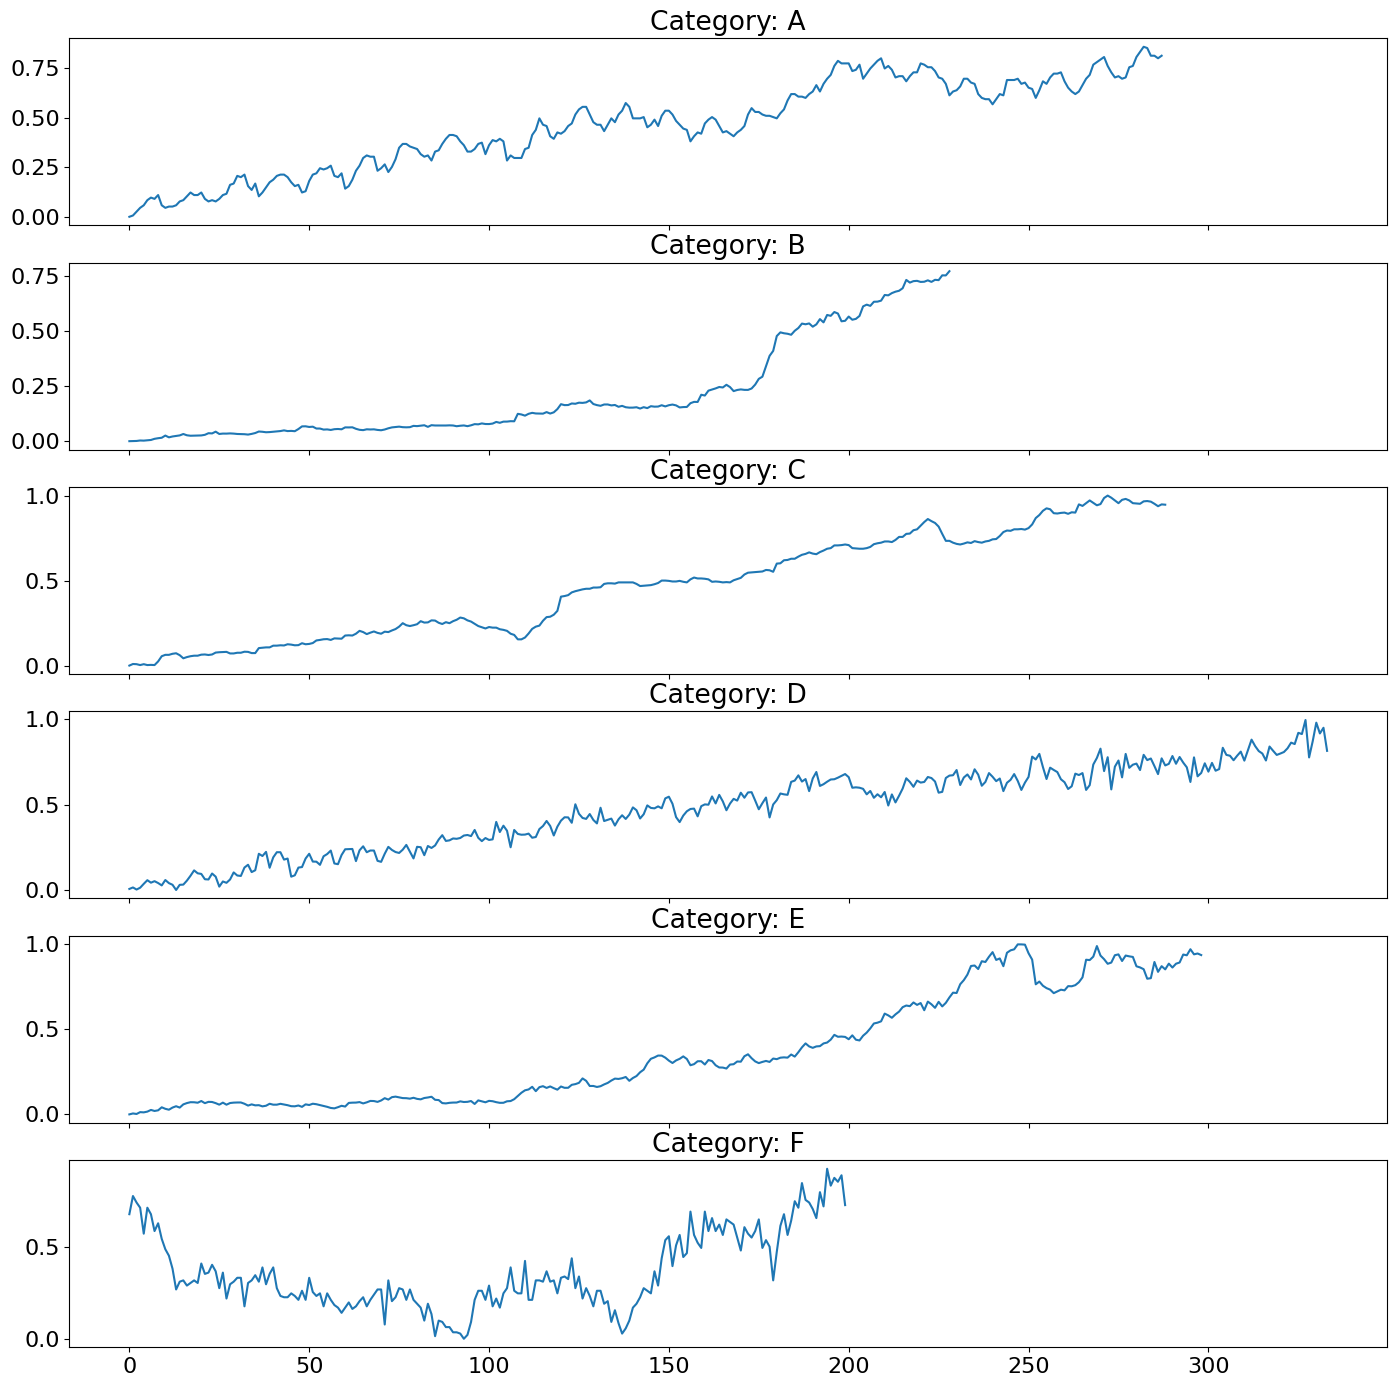

In [ ]:
inspect_data()

Sequential Train-Test split and normalization

In [ ]:
np.random.seed(seed)

test_size = 3800

np.random.shuffle(sequences)
np.random.shuffle(categories)
np.random.shuffle(valid_periods)

X_train_raw = sequences[:-test_size,:]
X_test_raw = sequences[-test_size:,:]

valid_periods_train = valid_periods[:-test_size,:]
valid_periods_test = valid_periods[-test_size:,:]

y_train = categories[:-test_size]
y_test = categories[-test_size:]

X_min = np.amin(X_train_raw,axis=0)
X_max = np.amax(X_train_raw,axis=0)


X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)

In [ ]:
window = 100
stride = 5

In [ ]:
future = sequences[:,-window:]
future = (future-X_min[-window:])/(X_max[-window:]-X_min[-window:])
future = np.expand_dims(future, axis=0)
future.shape

(1, 48000, 100)

In [ ]:
def build_sequences(X, y, window=200, stride=20, telescope=100):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    for i in X.shape[0]:
        # Take only meaningful features
        temp = X[i,:]
        # Save the label
        label = y[i]
        # Compute padding length
        padding_len = window - len(temp)%window
        # Create padding and concatenate it
        padding = np.zeros((padding_len,3), dtype='float32')
        temp = np.concatenate((temp,padding))
        # Build features windows with their corresponging labels
        idx = 0
        while idx+window <= len(temp):
            dataset.append(temp[idx:idx+window])
            labels.append(label)
            idx += stride
    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [ ]:
telescope = 50